In [1]:
% matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import curve_fit
from PIL import Image

j = complex(0,1)

# Properties of the Experiment

## Fourier Optics Theory

In fourier optics, the projection of the relationship between the $k$'s of the fourier transform and <i> the actual displacement on the screen </i> is given by

$$ x = \frac{\lambda f}{2 \pi}k $$

where $\lambda$ is the wavelength of the light and $f$ is the focal length of the lens. 

## Digital Fourier Transform Theory

The Fourier Transform is defined as

$$F(w) = \frac{1}{\sqrt{2 \pi}} \int_{- \infty}^{\infty} f(t)e^{-iwt}dt $$

Lets suppose that we are working digitally and have an array of times $t=t_0+n\Delta t$. Summing over all times then yields

$$F(w) = \frac{1}{\sqrt{2 \pi}}\sum_{n=0}^N f(t_0+n\Delta t)e^{-i wt_0}e^{-iwn\Delta t} \Delta t $$

Taking the non-n dependent terms out of the sum yields

$$F(w) = \frac{1}{\sqrt{2 \pi}}\Delta te^{-i wt_0}\sum_{n=0}^N f(t_0+n\Delta t)e^{-iwn\Delta t}  $$

The <b>sum</b> (not the factor out front) is <b> discrete Fourier transform function </b> $F_d (w)$. We can use g=np.fft.fft(f) and  w' = np.fft.fftfreq(f.size) to get arrays of $w'$ and $F(w)$ from

$$F_d(w) = \sum_{n=0}^N f(t_0+n\Delta t)e^{-i (2 \pi n w')}  $$

Notice that the term in the exponential is slightly different. In otherwords, the command np.fft.fftfreq(f.size) returns the array $w'$ and not $w$. We can renormalize the arrays using

$$ w = \frac{2 \pi}{\Delta t}w' $$

$$F =\frac{1}{\sqrt{2 \pi}}\Delta te^{-i wt_0} F_d  $$

We now have an array $F$ which we can plot as a function of $w$. This would yield a plot of the <b> continuous Fourier Transform </b>.

## Combining This Together

Since we normalize the area under the fourier transform, we need not worry about the array $F$ above. Our frequency array $w$ obtained by the fourier transform, however, needs to be multiplied by the following factor in order to correspond to the distances on the screen

$$x=\frac{2 \pi}{\Delta x} \frac{\lambda f}{2 \pi}w=\frac{\lambda f}{\Delta x} w$$

The first term $2\pi/\Delta x$ comes from the digital fourier transform properties; the second term $\lambda f/2\pi$ makes the $k$ space vectors correspond to actual distances on the screen, as explained in the Fourier Optics Theory section.

In [2]:
lam = 655e-9
f = 200e-3

Pix_Size = 6.45e-6
X_Pixels = 1360
Y_Pixels = 1024

In [3]:
def get_image_dimensions(image):
    y_width, x_width = image.shape
    x_arr = np.linspace(1, x_width, x_width) *Pix_Size
    y_arr = np.linspace(1, y_width, y_width) *Pix_Size
    
    return x_arr, y_arr, image

Go to 0.5 bc don't need negative values -0.5 to 0.

In [4]:
def get_simulation_dimensions(f_trans):
    ky_width, kx_width = f_trans.shape
    
    del_x = Pix_Size
    del_y = Pix_Size
    
    kx_arr = np.linspace(0, 1, kx_width)*(lam*f/del_x)
    ky_arr = np.linspace(0, 1, ky_width)*(lam*f/del_y)
    
    return kx_arr, ky_arr, f_trans

In [5]:
def sinc(x, a, R, b):
    return a*np.abs(np.sinc(R*(x-b)))

def square(x, A, a, b):
    return A*(np.heaviside(x-a,1)-np.heaviside(x-b,1))

In [6]:
def remove_baseline(im, n=20):
    baseline = im[0][0:n].mean()
    return im-baseline

In [7]:
def image_to_array(name):
    im = Image.open(name).convert('L')
    p = np.array(im)
    p = remove_baseline(p)
    p = p/p.sum()
    return p

In [8]:
def simulate_Fourier_2d(array):
    g=np.abs(np.fft.fft2(array))
    g = g/g.sum() #nomralize
    G = np.fft.fftshift( g ) #shift to small frequencies in the middle
    return np.abs(G) #returns intensity

In [9]:
def scale_axis(ax, scale):
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
    ax.xaxis.set_major_formatter(ticks_x)

In [10]:
def plot_image_and_fit(Image, ax1, ax2, ax3, image_type):
    
    if image_type is 'image':
        x, y, z = get_image_dimensions(Image)
    if image_type is 'simulation':
        x, y, z = get_simulation_dimensions(Image)
    ax1.pcolor(x, y, z)
    ax1.set_title('Image of Interest')

    hx, hy = z.sum(axis=0), z.sum(axis=1)
    
    ax2.plot(x, hx)
    (a, R, b), pcov = curve_fit(sinc, x, hx, p0=(np.amax(hx), 15267, x[np.argmax(hx)]))
    ax2.plot(x, sinc(x, a, R, b), color='r')
    ax2.set_xlim(b-10/R, b+10/R)
    
    ax3.plot(y, hy)
    (a, R, b), pcov = curve_fit(sinc, y, hy, p0=(np.amax(hy), 15267, y[np.argmax(hy)]))
    ax3.plot(y, sinc(y, a, R, b), color='r')
    ax3.set_xlim(b-10/R, b+10/R)
    
    ax2.set_title('X Profile')
    ax2.set_xlabel('Distance (mm)')
    ax2.set_ylabel('Inetnsity [arb]')
    scale_axis(ax2, 1000)

    ax3.set_title('Y Profile')
    ax3.set_xlabel('Distance (mm)')
    ax3.set_ylabel('Inetnsity [arb]')    
    scale_axis(ax3, 1000)

# Open Image

In [11]:
Image_Raw = image_to_array("Fourier_Oct_10/Squaretwo/Image_Raw.bmp")

# Plot Image

<IPython.core.display.Javascript object>


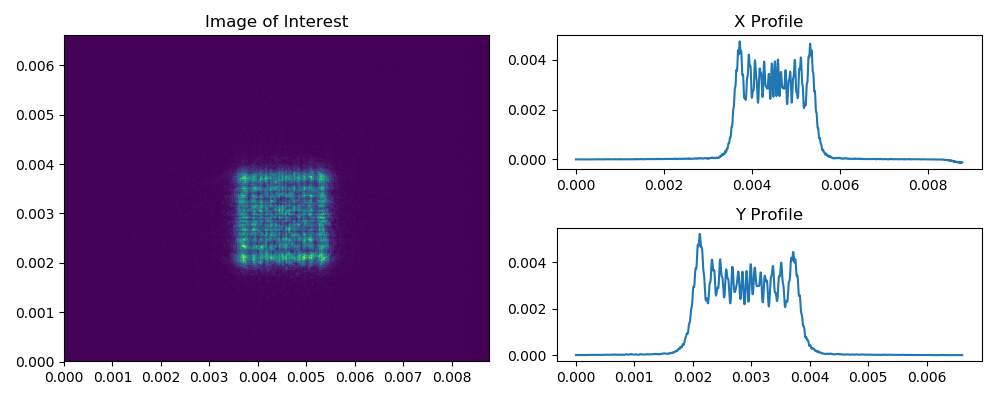

In [12]:
fig = plt.figure(figsize = (10,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

x, y, z = get_image_dimensions(Image_Raw)
ax1.pcolor(x, y, z)
ax1.set_title('Image of Interest')

hx, hy = z.sum(axis=0), z.sum(axis=1)
ax2.plot(x, hx)
ax2.set_title('X Profile')
ax3.plot(y, hy)
ax3.set_title('Y Profile')

#(A, a, b), pcov = curve_fit(square, x, hx, p0=(0.005, 0.0025, 0.00425))
#ax2.plot(x, square(x, A, a, b), color='r')

fig.tight_layout()
plt.show()

# Simulate Fourier Transform on Image

In [13]:
Fourier_Raw_Simulate = simulate_Fourier_2d(Image_Raw)

# Open Actual Fourier Transform on Image

In [14]:
Fourier_Raw_Actual = image_to_array("Fourier_Oct_10/Squaretwo/Fourier_Raw(sat).bmp")

# Plot Observed

<IPython.core.display.Javascript object>


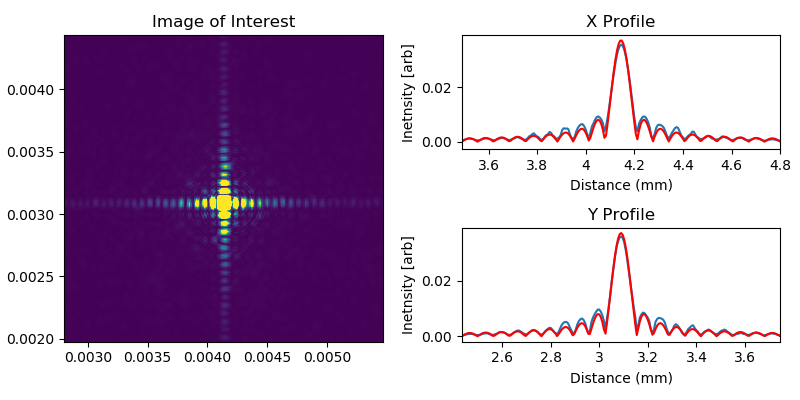

In [15]:
fig = plt.figure(figsize = (8,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

plot_image_and_fit(Fourier_Raw_Actual, ax1, ax2, ax3, 'image')

fig.tight_layout()
plt.show()

# Plot Simulated

<IPython.core.display.Javascript object>


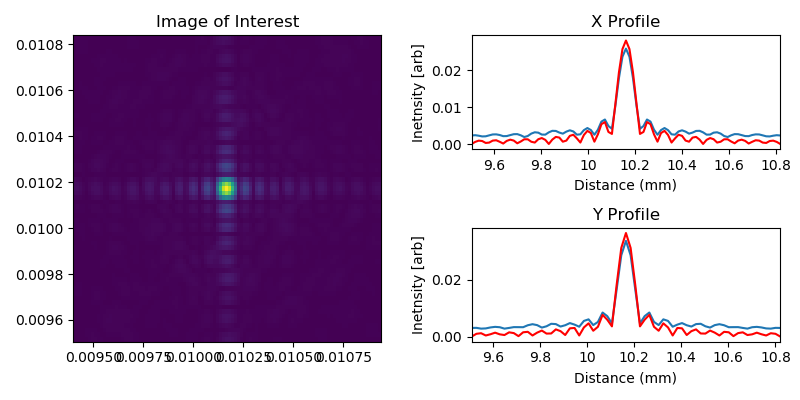

In [16]:
fig = plt.figure(figsize = (8,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

plot_image_and_fit(Fourier_Raw_Simulate, ax1, ax2, ax3, 'simulation')

fig.tight_layout()
plt.show()